# <p style="text-align:center;">Data Overview</p>
Welcome to the data exploration notebook. Here, we will load, inspect, and analyze the training and test datasets for power spot price forecasting. The goal is to understand the structure, quality, and relationships within the data before modeling.

## <p style="text-align:center;">Required Libraries</p>
We import the main libraries for data manipulation and visualization.

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## <p style="text-align:center;">Data Import</p>
We load the training and test datasets for further analysis.

In [141]:
X_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_train.csv")
X_test = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_test.csv")
y_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\y_train.csv")

In [142]:
# Display the first 5 rows of the training features
X_train.head(5)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [143]:
# Merge features and target for exploration
XY_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
print(XY_train.columns)

Index(['DELIVERY_START_x', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nucelear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std',
       'predicted_spot_price', 'DELIVERY_START_y', 'spot_id_delta'],
      dtype='object')


In [144]:
def extract_datetime_features(df, datetime_col="DELIVERY_START_x", country_code="FR"):
    """
    Add time-based features to a DataFrame from a datetime column.

    Parameters:
    - df: pandas DataFrame
    - datetime_col: name of the column containing dates
    - country_code: country code for holidays (e.g., 'FR' for France)

    Returns:
    - enriched df (with index set to datetime_col)
    """

    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], utc=True)

    country_holidays = holidays.CountryHoliday(country_code)

    df["month"] = df[datetime_col].dt.month
    df["day"] = df[datetime_col].dt.day
    df["hour"] = df[datetime_col].dt.hour
    df["weekday"] = df[datetime_col].dt.weekday
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
    df["peak_hours"] = df["hour"].apply(lambda x: 1 if 7 <= x < 23 else 0)

    def period_of_day(hour):
        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 18:
            return "afternoon"
        elif 18 <= hour < 23:
            return "evening"
        else:
            return "night"

    df["period"] = df["hour"].apply(period_of_day)
    le = LabelEncoder()
    df["period"] = le.fit_transform(df["period"])

    df["is_holiday"] = df[datetime_col].dt.date.apply(lambda x: x in country_holidays).astype(int)

    try:
        df["is_dst"] = df[datetime_col].dt.dst().notna().astype(int)
    except Exception:
        df["is_dst"] = 0

    df.set_index(datetime_col, inplace=True)

    return df


XY_train = extract_datetime_features(XY_train, datetime_col="DELIVERY_START_x", country_code="FR")
XY_train.head(10)

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,DELIVERY_START_y,spot_id_delta,month,day,hour,weekday,is_weekend,peak_hours,period,is_holiday,is_dst
DELIVERY_START_x,,,,,,,,,,,,,,,,,,,,
2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,2022-01-01 02:00:00+01:00,-36.874770,1,1,1,5,1,0,3,1,0
2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,2022-01-01 03:00:00+01:00,-12.643588,1,1,2,5,1,0,3,1,0
2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,2022-01-01 04:00:00+01:00,-1.950193,1,1,3,5,1,0,3,1,0
2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,2022-01-01 05:00:00+01:00,1.938272,1,1,4,5,1,0,3,1,0
2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,2022-01-01 06:00:00+01:00,0.199907,1,1,5,5,1,0,3,1,0
2022-01-01 06:00:00+00:00,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN,2022-01-01 07:00:00+01:00,-0.943992,1,1,6,5,1,0,2,1,0
2022-01-01 07:00:00+00:00,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN,2022-01-01 08:00:00+01:00,-2.770881,1,1,7,5,1,1,2,1,0
2022-01-01 08:00:00+00:00,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN,2022-01-01 09:00:00+01:00,-17.576596,1,1,8,5,1,1,2,1,0
2022-01-01 09:00:00+00:00,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN,2022-01-01 10:00:00+01:00,-12.352031,1,1,9,5,1,1,2,1,0


In [145]:
# Display the first rows of the merged dataset
XY_train.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,DELIVERY_START_y,spot_id_delta,month,day,hour,weekday,is_weekend,peak_hours,period,is_holiday,is_dst
DELIVERY_START_x,,,,,,,,,,,,,,,,,,,,
2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,2022-01-01 02:00:00+01:00,-36.874770,1,1,1,5,1,0,3,1,0
2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN,2022-01-01 03:00:00+01:00,-12.643588,1,1,2,5,1,0,3,1,0
2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN,2022-01-01 04:00:00+01:00,-1.950193,1,1,3,5,1,0,3,1,0
2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN,2022-01-01 05:00:00+01:00,1.938272,1,1,4,5,1,0,3,1,0
2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN,2022-01-01 06:00:00+01:00,0.199907,1,1,5,5,1,0,3,1,0


In [146]:
X_test = extract_datetime_features(X_test, datetime_col="DELIVERY_START", country_code="FR")

In [147]:
# Check for missing values and dataset size
print(XY_train.isna().sum())
print("\nNumber of rows: " + str(len(XY_train)))

load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
DELIVERY_START_y                    0
spot_id_delta                       0
month                               0
day                                 0
hour                                0
weekday                             0
is_weekend                          0
peak_hours                          0
period                              0
is_holiday                          0
is_dst                              0
dtype: int64

Number of rows: 10605


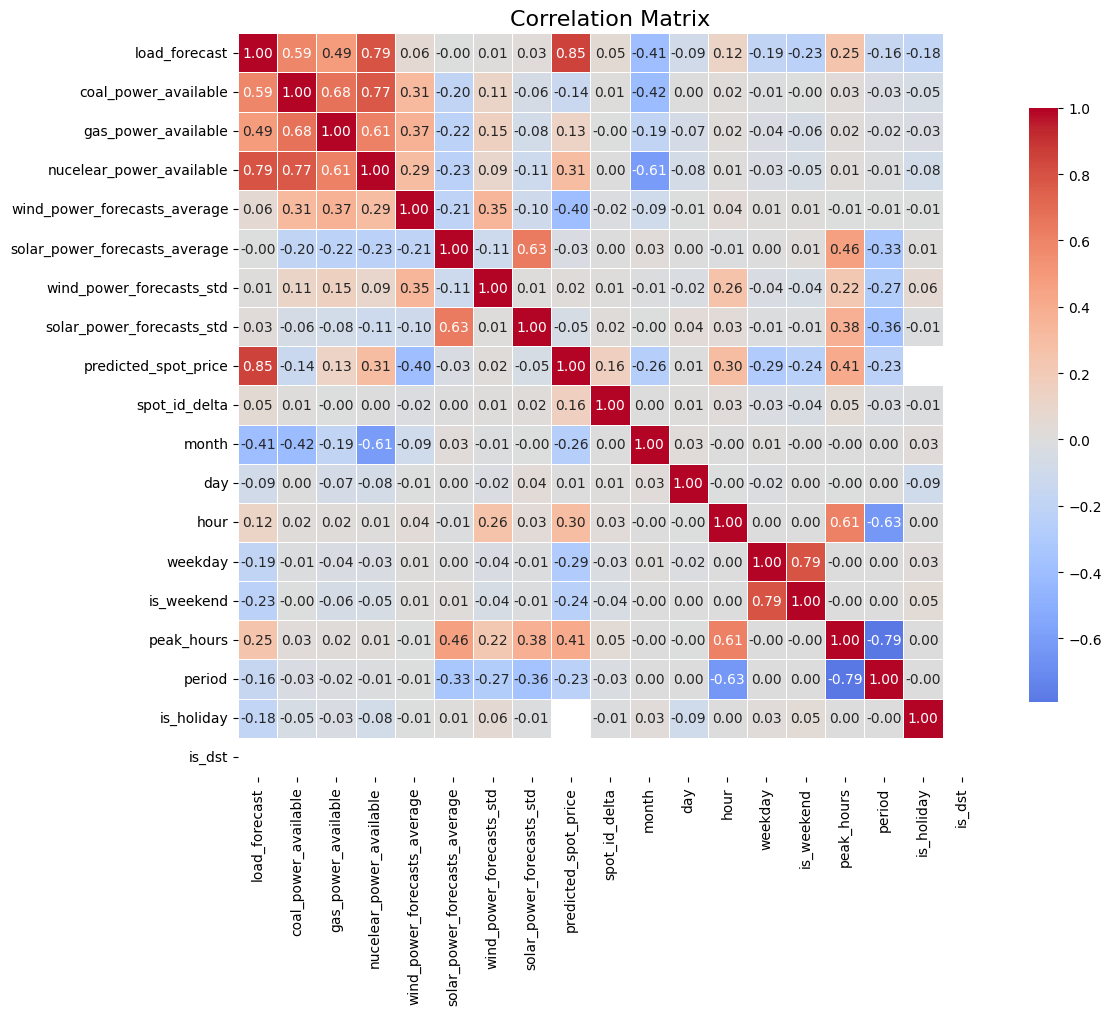

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns
correlation_matrix = XY_train.corr(numeric_only=True)

plt.figure(figsize=(12, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
),

plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


We observe that the *spot_id_delta* variable is only weakly correlated with the other columns. This is especially surprising since it is also only weakly correlated with *predicted_spot_price*. The latter has very little available data, as it contains a large number of missing values.

We will get rid of this variable and try to input the values of the other columns with missing values.


# Handling missing values

For every variables except load_forecast we will input the mean as there are only a fewmissing values (maximum 24).

In [149]:
cols_to_impute_by_mean = [
    "coal_power_available",
    "gas_power_available",
    "nucelear_power_available",
    "wind_power_forecasts_average",
    "solar_power_forecasts_average",
    "wind_power_forecasts_std",
    "solar_power_forecasts_std"
]
# Impute missing values with the mean for specified columns
for col in cols_to_impute_by_mean:
    if col in XY_train.columns:
        mean_val = XY_train[col].mean()
        XY_train[col] = XY_train[col].fillna(mean_val)

# Impute missing values in the test set using the same mean values
for col in cols_to_impute_by_mean:
    if col in X_test.columns:
        mean_val = X_test[col].mean()
        X_test[col] = X_test[col].fillna(mean_val)


For the load_forecast variable, we will use KMeans-based imputation.

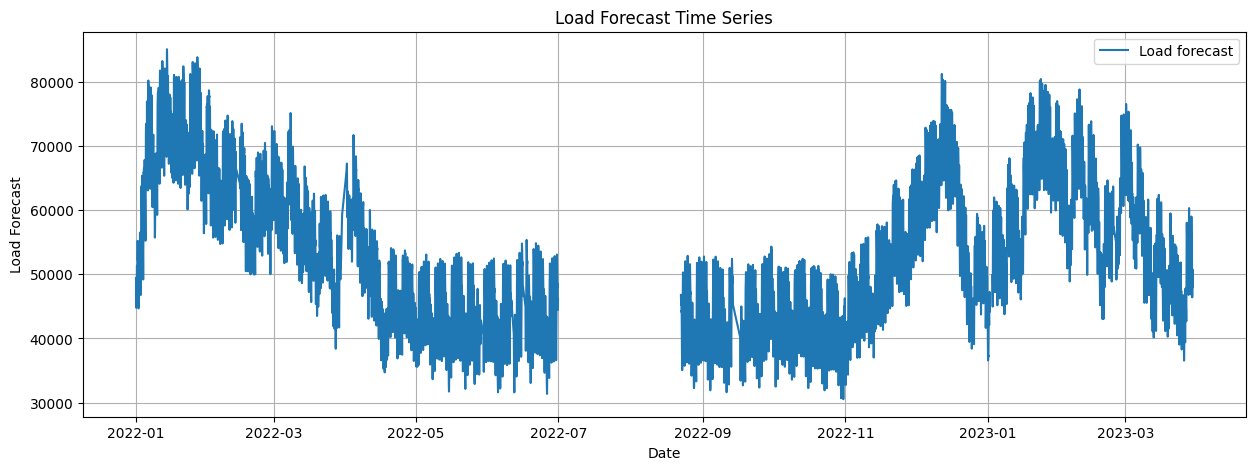

In [150]:
plt.figure(figsize=(15, 5))
plt.plot(XY_train.index, XY_train['load_forecast'], label='Load forecast')
plt.xlabel('Date')
plt.ylabel('Load Forecast')
plt.title('Load Forecast Time Series')
plt.legend()
plt.grid(True)
plt.show()

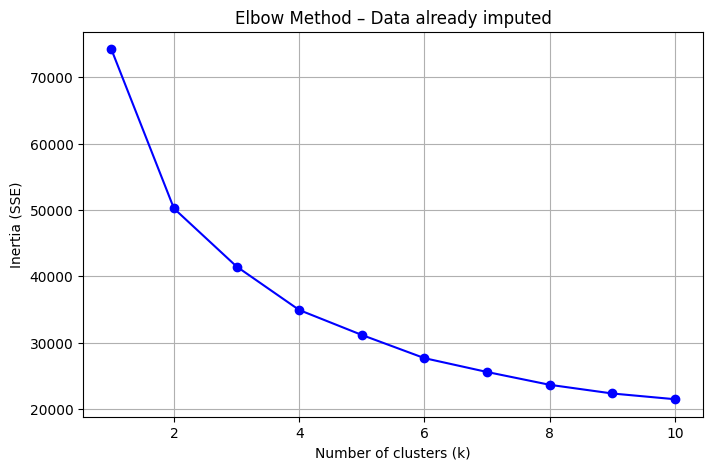

In [151]:
# 1. Columns to analyze
cols_to_cluster = [
    "coal_power_available",
    "gas_power_available",
    "nucelear_power_available",
    "wind_power_forecasts_average",
    "solar_power_forecasts_average",
    "wind_power_forecasts_std",
    "solar_power_forecasts_std"
]

# 2. Extract data (already without NaNs)
X = XY_train[cols_to_cluster].copy()

# 3. Standardize (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Elbow method
inertias = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 5. Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method – Data already imputed")
plt.grid(True)
plt.show()


In [152]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Columns for clustering (excluding load_forecast)
cols_for_clustering = [
    "coal_power_available",
    "gas_power_available",
    "nucelear_power_available",
    "wind_power_forecasts_average",
    "solar_power_forecasts_average",
    "wind_power_forecasts_std",
    "solar_power_forecasts_std"
]

# 1. Training on XY_train

# a. Prepare clustering data
X_cluster_train = XY_train[cols_for_clustering].copy()
assert X_cluster_train.isna().sum().sum() == 0, "There are NaNs in the clustering columns in XY_train!"

# b. Standardize
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_cluster_train)

# c. KMeans clustering
k = 6
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
XY_train['cluster'] = kmeans.fit_predict(X_scaled_train)

# d. Mean load_forecast by cluster (from XY_train only)
load_means = XY_train.groupby('cluster')['load_forecast'].mean()

# e. Global mean (fallback value if cluster not found in X_test)
default_load_value = XY_train['load_forecast'].mean()

# f. Impute in XY_train
def impute_train(row):
    if pd.isna(row['load_forecast']):
        return load_means.loc[row['cluster']]
    else:
        return row['load_forecast']

XY_train['load_forecast'] = XY_train.apply(impute_train, axis=1)

# 2. Apply to X_test

# a. Prepare clustering data
X_cluster_test = X_test[cols_for_clustering].copy()
assert X_cluster_test.isna().sum().sum() == 0, "There are NaNs in the clustering columns in X_test!"

# b. Standardize with scaler fitted on XY_train
X_scaled_test = scaler.transform(X_cluster_test)

# c. Predict clusters with trained KMeans
X_test['cluster'] = kmeans.predict(X_scaled_test)

# d. Impute in X_test with fallback if cluster not found
def impute_test(row):
    if pd.isna(row['load_forecast']):
        return load_means.get(row['cluster'], default_load_value)
    else:
        return row['load_forecast']

X_test['load_forecast'] = X_test.apply(impute_test, axis=1)



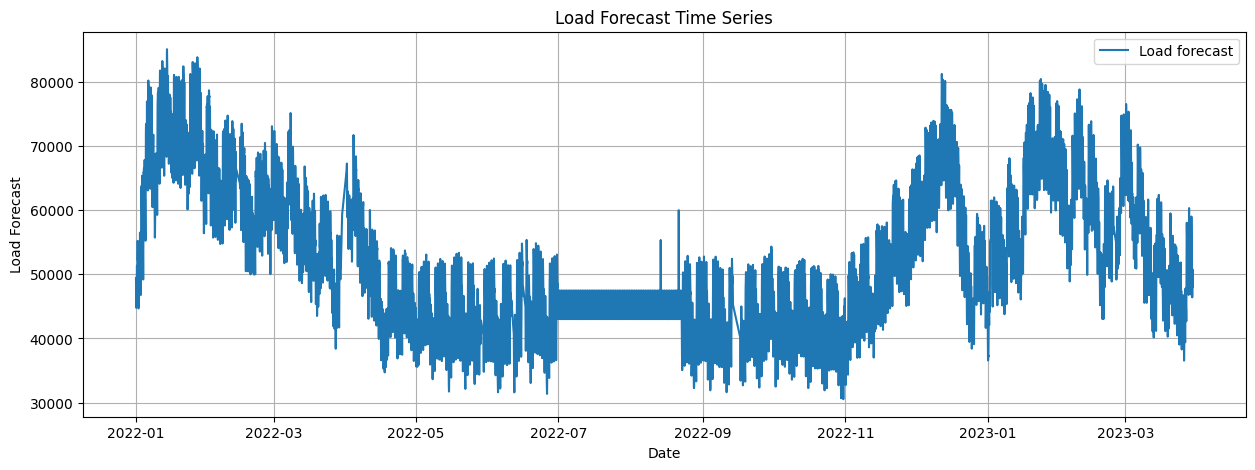

In [153]:
# Plot the spot price time series
plt.figure(figsize=(15, 5))
plt.plot(XY_train.index, XY_train['load_forecast'], label='Load forecast')
plt.xlabel('Date')
plt.ylabel('Load Forecast')
plt.title('Load Forecast Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [154]:
# Check for missing values and dataset size
print(XY_train.isna().sum())
print("\nNumber of rows: " + str(len(XY_train)))

load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average       0
wind_power_forecasts_std            0
solar_power_forecasts_std           0
predicted_spot_price             8759
DELIVERY_START_y                    0
spot_id_delta                       0
month                               0
day                                 0
hour                                0
weekday                             0
is_weekend                          0
peak_hours                          0
period                              0
is_holiday                          0
is_dst                              0
cluster                             0
dtype: int64

Number of rows: 10605


In [155]:
# Check for missing values and dataset size
print(X_test.isna().sum())
print("\nNumber of rows: " + str(len(X_test)))

load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average       0
wind_power_forecasts_std            0
solar_power_forecasts_std           0
predicted_spot_price             1536
month                               0
day                                 0
hour                                0
weekday                             0
is_weekend                          0
peak_hours                          0
period                              0
is_holiday                          0
is_dst                              0
cluster                             0
dtype: int64

Number of rows: 4942


In [156]:
X_train = XY_train.drop(columns=['predicted_spot_price', 'DELIVERY_START_y', 'cluster', 'spot_id_delta'])
Y_train = XY_train['spot_id_delta']
X_test = X_test.drop(columns=['predicted_spot_price', 'cluster'])

In [ ]:
# Ensure the column exists
X_test["DELIVERY_START"] = pd.to_datetime(X_test.index)

# Reorder columns to put "DELIVERY_START" first
cols = ["DELIVERY_START"] + [col for col in X_train.columns if col != "DELIVERY_START"]
X_test = X_test[cols]

# Ensure the column exists
X_train["DELIVERY_START"] = pd.to_datetime(X_train.index)

# Reorder columns to put "DELIVERY_START" first
cols = ["DELIVERY_START"] + [col for col in X_train.columns if col != "DELIVERY_START"]
X_train = X_train[cols]

Y_train = Y_train.to_frame()
Y_train = Y_train.copy()
Y_train["DELIVERY_START"] = pd.to_datetime(Y_train.index)

# Reorder columns
cols = ["DELIVERY_START"] + [col for col in Y_train.columns if col != "DELIVERY_START"]
Y_train = Y_train[cols]



In [158]:
X_train.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\preprocessed_data\X_train.csv", index=False)
X_test.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\preprocessed_data\X_test.csv", index=False)
Y_train.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\preprocessed_data\Y_train.csv", index=False)